In [62]:
import json
import re
import string
import time
import distance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as cv
from pandas import DataFrame
#from knn import mlp
from collections import OrderedDict
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
#from knn.backend import lasagne
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

with open('train.json') as f:
    data=json.load(f)
    
print (type(data))

<class 'list'>


In [52]:
print(data[0]['cuisine'])

greek


In [44]:

for index in range(10):
    for key in data[index]:
        print(data[index][key])


10259
greek
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
25693
southern_us
['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']
20130
filipino
['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers']
22213
indian
['water', 'vegetable oil', 'wheat', 'salt']
13162
indian
['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'butter', 'salt', 'lemon juice', 'water', 'chili powder', 'passata', 'oil', 'ground cumin', 'boneless chicken skinless thigh', 'garam masala', 'double cream', 'natural yogurt', 'bay leaf']
6602
jamaican
['plain flour', 'sugar', 'butter', 'eggs', 'fresh ginger root', 'salt', 'ground cinnamon', 'milk', 'vanilla extrac

In [45]:
import itertools
from operator import itemgetter
#sort cooking data by cuisine key
cooking=sorted(data, key=itemgetter('cuisine'))

In [46]:
#display data group by cuisine
for key, value in itertools.groupby(cooking, key=itemgetter('cuisine')):
    print (key)
    

brazilian
british
cajun_creole
chinese
filipino
french
greek
indian
irish
italian
jamaican
japanese
korean
mexican
moroccan
russian
southern_us
spanish
thai
vietnamese


In [53]:
#find the longest ingredient and ID
max=0
pos=0
length=len(data)
for x in range(length):
    if len( data[x]['ingredients'])>max:
        max=len(data[x]['ingredients'])
        pos=x
print(max)
print(data[pos])

65
{'id': 3885, 'cuisine': 'italian', 'ingredients': ['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'NeufchÃ¢tel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated p

In [64]:

cuisine = []
ingre = []
full = []
for i in range(length):
    cuisine.append(data[i]['cuisine'])
    for j in range(len(data[i]['ingredients'])):
        ingre.append(data[i]['ingredients'][j])
    li = [y for y in ingre]
    li = ",".join(map(str, li))
    full.append(li)
    ingre = []
    #if(i == 5000):
    #    break
    if(i%5000 == 0):
        print(i)
df = pd.DataFrame({'cuisine':cuisine,'ingredients':full})

print(df.head())

0
5000
10000
15000
20000
25000
30000
35000
       cuisine                                        ingredients
0        greek  romaine lettuce,black olives,grape tomatoes,ga...
1  southern_us  plain flour,ground pepper,salt,tomatoes,ground...
2     filipino  eggs,pepper,salt,mayonaise,cooking oil,green c...
3       indian                     water,vegetable oil,wheat,salt
4       indian  black pepper,shallots,cornflour,cayenne pepper...


In [65]:
x_train=df['ingredients']
y_train=df.cuisine


In [50]:
#isolates only unique cuisin and ingredients and sort them aplphabetically
unique_cuisines, cuisine_counts=np.unique(all_cuisines, return_counts=True)
unique_ingredients, ingredient_counts=np.unique(all_ingredients, return_counts=True)
for cuisine in unique_cuisines:
    print(cuisine)

brazilian
british
cajun_creole
chinese
filipino
french
greek
indian
irish
italian
jamaican
japanese
korean
mexican
moroccan
russian
southern_us
spanish
thai
vietnamese


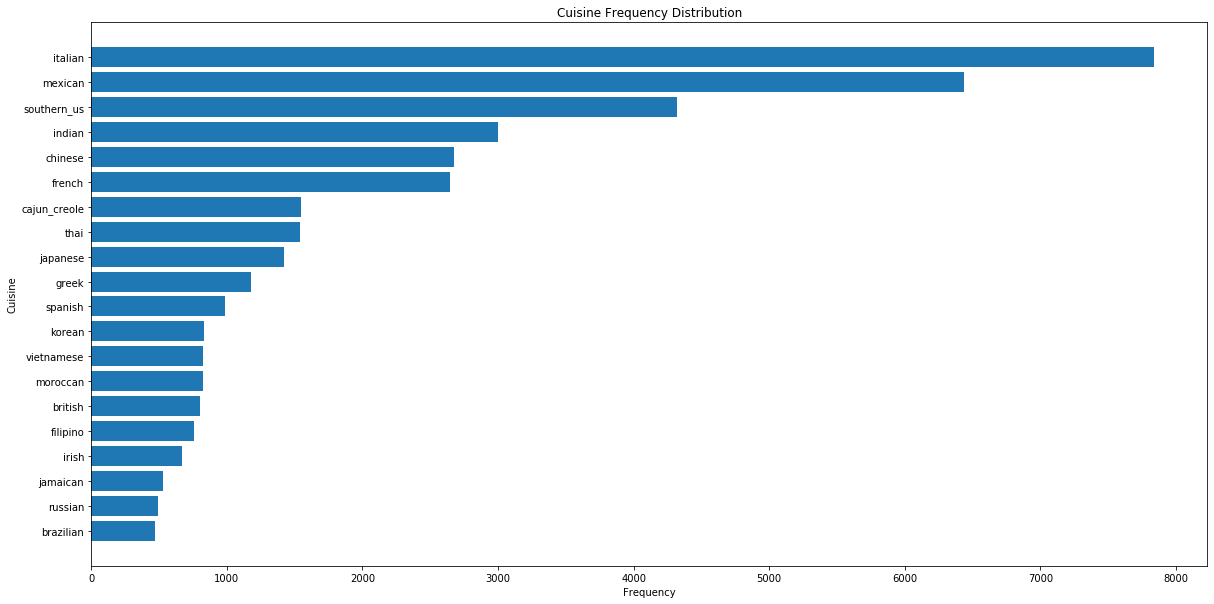

In [51]:
"""
Explore cuisine frequency in the dataset.
"""

# Sort the cuisines by frequency.
cuisine_counts, unique_cuisines = zip(*sorted(zip(cuisine_counts, unique_cuisines)))

# Plot the frequencies.
pos = np.arange(len(unique_cuisines)) + 0.5
plt.figure(figsize=(20, 10))
plt.barh(pos, cuisine_counts, align='center')
plt.yticks(pos, unique_cuisines)
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.title('Cuisine Frequency Distribution')
plt.show()

In [55]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [56]:
cuisine_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [66]:
x_traincv=cuisine_vector.fit_transform(x_train)
x_traincv.shape

(39774, 3183)

In [67]:
from sklearn.naive_bayes import MultinomialNB

MNB=MultinomialNB()
MNB.fit(x_traincv, y_train)
MNB.score(x_traincv, y_train)

0.7460149846633479